In [1]:
import pandas as pd
df_ml = pd.read_csv("../data/processed/ML_Chile_2022-12-27.csv")
df_ml.dropna(subset=["tweet_text"], inplace=True)
df_ml = df_ml[df_ml["sentiment"] != "others"]
df_ml.shape

(28, 8)

In [2]:
def df_to_list(df):
    texts = df["tweet_text"]
    data = []
    for text in texts:
        data.append(text)
    return data

In [3]:
import numpy as np
import torch
from transformers import BertModel, BertTokenizer
tokenizer_español = BertTokenizer.from_pretrained("../pytorch/", do_lower_case=False)
model = BertModel.from_pretrained("../pytorch")

Some weights of the model checkpoint at ../pytorch were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from src import Features
inputs = df_to_list(df_ml)
inputs = Features.bert_encoder(inputs, tokenizer_español)
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [5]:
max_poll = Features.max_polling(last_hidden_states)
mean_poll = Features.mean_polling(last_hidden_states)

In [6]:
data_ml = {
        "max_polling_std": Features.std_normalization(max_poll),
        "max_polling_z_score": Features.z_score_normalization(max_poll),
        "max_polling_max": Features.min_max_normalization(max_poll),
        "mean_polling_std": Features.std_normalization(mean_poll),
        "mean_polling_z_score": Features.z_score_normalization(mean_poll),
        "mean_polling_max": Features.min_max_normalization(mean_poll),
    }

In [7]:
def find_indexs(list, value):
    list_aux = list.copy()
    output = []
    while True:
        try:
            index = list_aux.index(value)
            output.append(index)
            list_aux[index] = None
        except ValueError:
            break
    return output

# agrupamiento

In [8]:
import sys

valor_minimo = sys.float_info.min
print(valor_minimo)

2.2250738585072014e-308


# k-means

In [9]:
# k-means
from sklearn.cluster import KMeans
from sklearn import metrics
agrupamiento = {}
metricas = {}
for K in range(2, 8):
    si = []
    vp = []
    for key, value in data_ml.items():
        if key not in metricas:
            metricas[key] = {
                "silhouettes_by_k_centroids": [],
                "VP_by_k_centroids": [],
            }
        # value shape: (77, 768)
        value = np.array(value)
        kmeans = KMeans(
            n_clusters=K,
            init="random",
            max_iter=1000,
            random_state=1,
            n_init=1,
        )
        cluster_labels = kmeans.fit_predict(value)
        centers = kmeans.cluster_centers_
        agrupamiento[key] = list(cluster_labels)
        variances = []
        for k in range(K):
            variance = Features.cluster_variance(value, cluster_labels, centers, k)
            variances.append(variance)
        avg_variance = sum(variances)/len(variances)
        vp.append(avg_variance)
        si.append(metrics.silhouette_score(
            value, kmeans.labels_, metric="sqeuclidean"))
        metricas[key]["silhouettes_by_k_centroids"].append(metrics.silhouette_score(
            value, kmeans.labels_, metric="sqeuclidean"))
        metricas[key]["VP_by_k_centroids"].append(avg_variance)

# metricas

# Visualización de los resultados de la metricas para encontrar el k-óptimo.

optimo: 0 , x(optimo): 2, y(optimo): 0.4592247524340892
optimo: 0 , x(optimo): 2, y(optimo): 0.14723249662075902
optimo: 1 , x(optimo): 3, y(optimo): 0.5843151428284018
optimo: 0 , x(optimo): 2, y(optimo): 0.28129529780370527
optimo: 3 , x(optimo): 5, y(optimo): 0.16238685512714382
optimo: 0 , x(optimo): 2, y(optimo): 0.47285030873412837


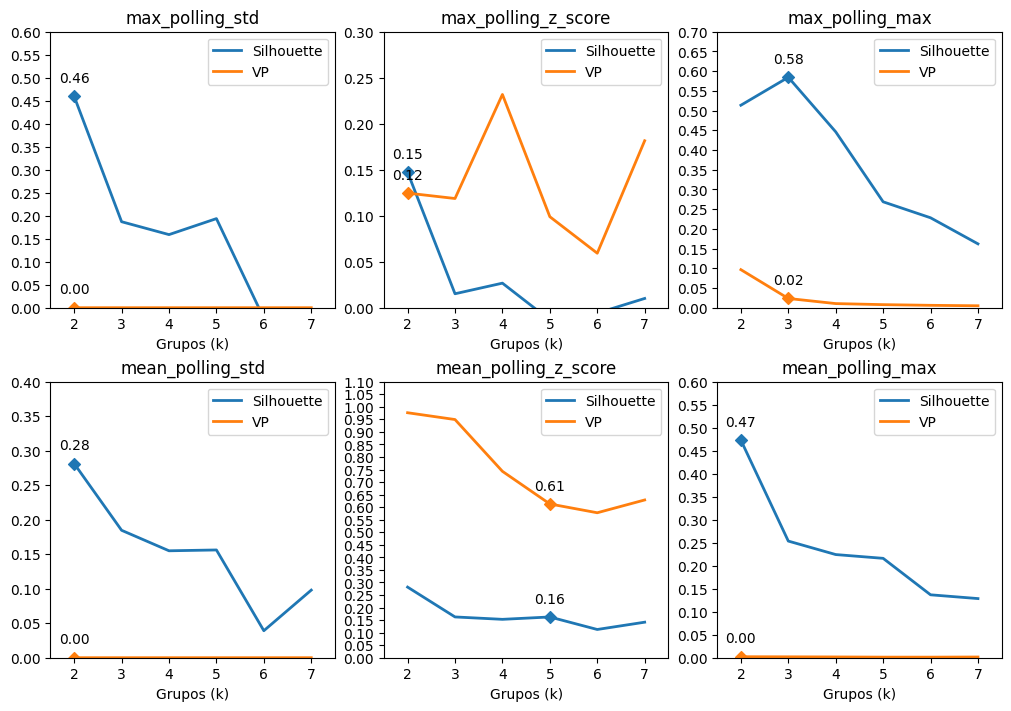

In [10]:
import matplotlib.pyplot as plt
#plt.style.use('_mpl-gallery')
x = range(2, 8)
k_optimos = []
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 7),
                        layout="constrained")
for ax, metricas_key in zip(axs.flat, metricas.keys()):
    sI = metricas[metricas_key]["silhouettes_by_k_centroids"]
    vP = Features.decimal_scaling_normalization(np.array(metricas[metricas_key]["VP_by_k_centroids"]))
    optimo = Features.optimo_k(sI, vP)
    k_optimos.append(optimo)
    print(f"optimo: {optimo} , x(optimo): {x[optimo]}, y(optimo): {sI[optimo]}")
    # plot

    ax.plot(x, sI, linewidth=2.0, label="Silhouette")
    ax.plot(x, vP, linewidth=2.0, label="VP")
    ax.scatter([x[optimo]], [sI[optimo]], marker="D")
    ax.scatter(x[optimo], vP[optimo], marker="D")
    y_max_lim = max([max(vP), max(sI)])
    y_max_lim = round(y_max_lim, 1) + 0.1
    ax.set(xlim=(x[0] - 0.5, x[-1] + 0.5), xticks=np.arange(x[0], x[-1] + 1),
        ylim=(0, y_max_lim), yticks=np.arange(0, y_max_lim + 0.05, 0.05))
    ax.set_xlabel("Grupos (k)")

    label0 = "{:.2f}".format(sI[optimo])
    ax.annotate(label0,
                (x[optimo],sI[optimo]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    label1 = "{:.2f}".format(vP[optimo])
    ax.annotate(label1,
                (x[optimo],vP[optimo]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    ax.set_title(f"{metricas_key}")
    ax.legend()
k_optimos = np.array(k_optimos) + 2

plt.show()

# visualización de resultados de analisis de sentimiento en los grupos creados

In [11]:
k_optimos

array([2, 2, 3, 2, 5, 2])

In [12]:
i=0
for key, value in data_ml.items():
    kmeans = KMeans(
        n_clusters=k_optimos[i],
        init="random",
        max_iter=100,
        random_state=1,
        n_init=1,
    ).fit(value)
    agrupamiento[key] = [list(kmeans.labels_), k_optimos[i]]
    i += 1

clusters = {}
for key, value in agrupamiento.items():
    clusters[key] = {}
    for k in range(value[1]):
        clusters[key][f"grupo {k + 1}"] = df_ml.iloc[find_indexs(agrupamiento[key][0], k)]

# preprocesado vs sentimiento.
sentiment_analysis = {}
i=0
for kesI, value0 in clusters.items():
    sentiment_analysis[kesI] = {}
    for kevP, value1 in value0.items():
        sentiment = dict(value1["sentiment"].value_counts())
        sentiment_values = list(sentiment.values())
        sentiment_labels = list(sentiment.keys())
        sentiment_analysis[kesI][kevP] = {f"{label}": value for label, value in zip(sentiment_labels, sentiment_values)}

sentiment_analysis


{'max_polling_std': {'grupo 1': {'sadness': 5},
  'grupo 2': {'anger': 16, 'sadness': 6, 'joy': 1}},
 'max_polling_z_score': {'grupo 1': {'sadness': 6, 'anger': 2},
  'grupo 2': {'anger': 14, 'sadness': 5, 'joy': 1}},
 'max_polling_max': {'grupo 1': {'sadness': 5, 'anger': 1},
  'grupo 2': {'anger': 3, 'sadness': 2, 'joy': 1},
  'grupo 3': {'anger': 12, 'sadness': 4}},
 'mean_polling_std': {'grupo 1': {'sadness': 5, 'joy': 1, 'anger': 1},
  'grupo 2': {'anger': 15, 'sadness': 6}},
 'mean_polling_z_score': {'grupo 1': {'sadness': 5, 'joy': 1, 'anger': 1},
  'grupo 2': {'anger': 3},
  'grupo 3': {'anger': 9, 'sadness': 5},
  'grupo 4': {'anger': 2, 'sadness': 1},
  'grupo 5': {'anger': 1}},
 'mean_polling_max': {'grupo 1': {'sadness': 6, 'anger': 1, 'joy': 1},
  'grupo 2': {'anger': 15, 'sadness': 5}}}

In [32]:
lst = [[1,2,3], [3,3]]
def colours(lst):
    print(lst)
    outer = []
    inner = []
    outer_colours = [0, 2, 4, 8, 10]
    inner_colours = range(20)
    i0 = 0
    i1 = 0
    for l in lst:
        outer.append(outer_colours[i0])
        for _ in l:
            inner.append(inner_colours[i1])
            i1 += 1
        i0 += 1
        i1 = i0 * 4
    return outer, inner
colours(lst)

[[1, 2, 3], [3, 3]]


([0, 2], [0, 1, 2, 4, 5])

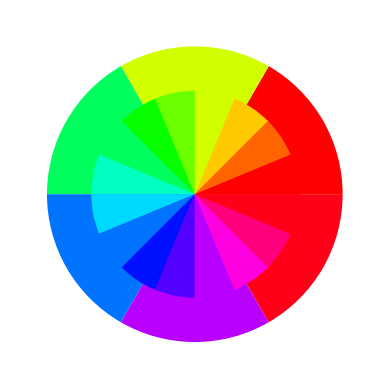

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Define el color exterior de la dona
color_exterior = 'orange'

# Genera una paleta de colores basada en el color exterior
num_secciones_interiores = 16  # Número de secciones interiores
num_secciones_exteriores = 6  # Número de secciones exteriores
cmap = plt.cm.get_cmap('hsv', num_secciones_interiores)
colores_interiores = cmap(np.arange(num_secciones_interiores))
colores_exteriores = cmap(np.linspace(0, 1, num_secciones_exteriores))

# Dibuja la dona
fig, ax = plt.subplots()

# Dibuja las secciones exteriores de la dona
ax.pie([1/num_secciones_exteriores]*num_secciones_exteriores, colors=colores_exteriores, radius=1.0)

# Dibuja las secciones interiores de la dona
ax.pie([1]*num_secciones_interiores, colors=colores_interiores, radius=0.7)

# Ajusta los aspectos visuales
ax.set(aspect='equal')

# Muestra el gráfico
plt.show()


In [14]:
def list_flatten(lst):
    outputs = []
    for l in lst:
        for e in l:
            outputs.append(e)
    return outputs

[[5], [16, 6, 1]]
[[6, 2], [14, 5, 1]]
[[5, 1], [3, 2, 1], [12, 4]]
[[5, 1, 1], [15, 6]]
[[5, 1, 1], [3], [9, 5], [2, 1], [1]]
[[6, 1, 1], [15, 5]]


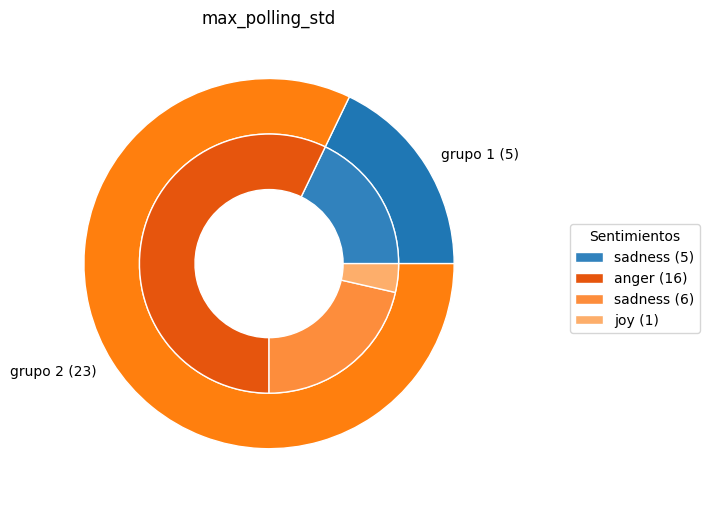

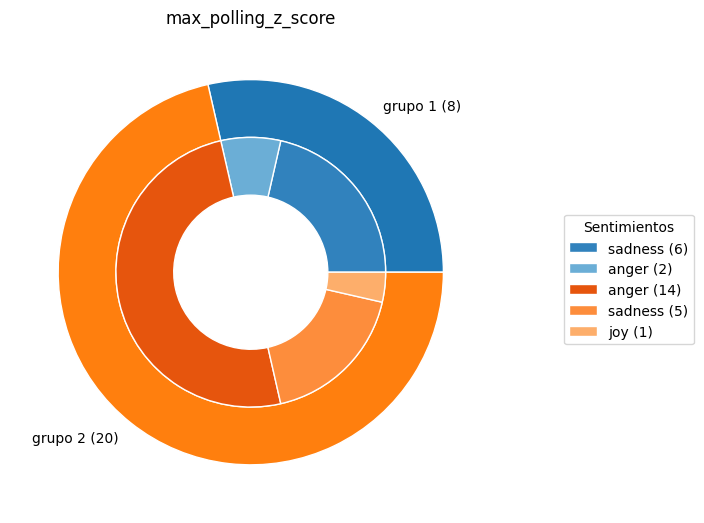

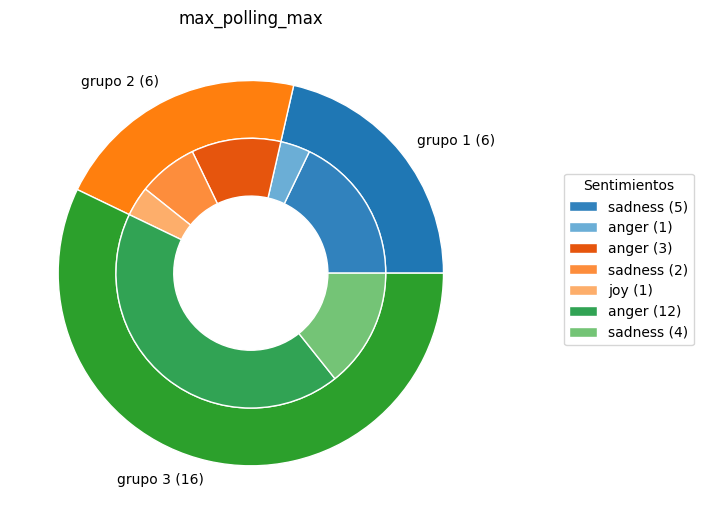

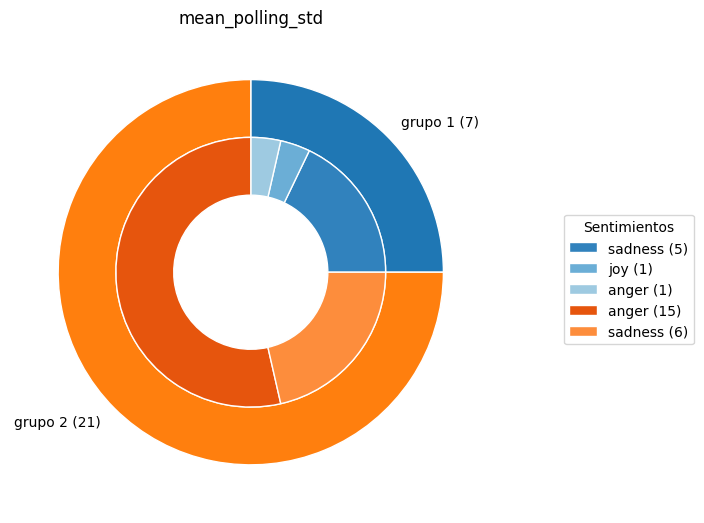

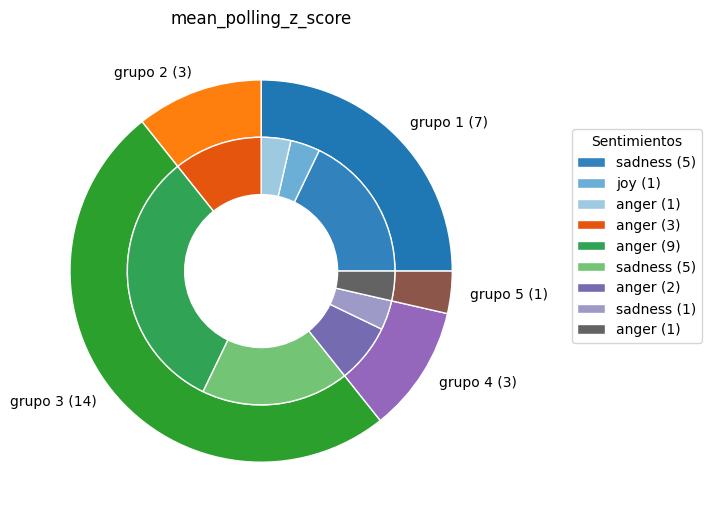

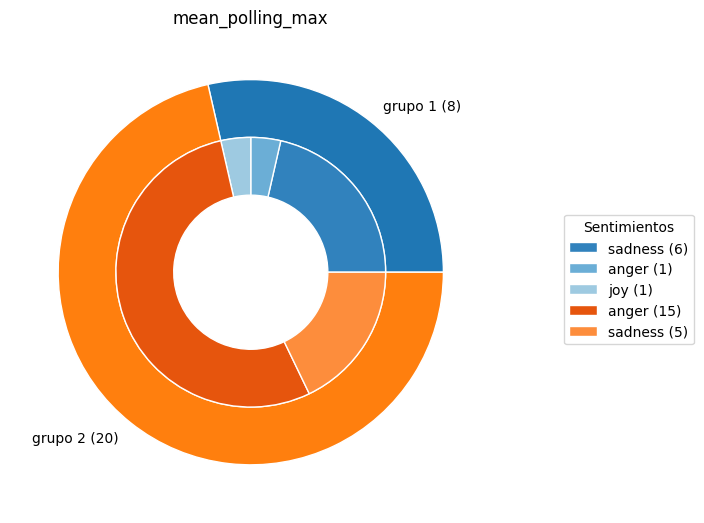

In [33]:
for key in sentiment_analysis.keys():
       fig, ax = plt.subplots(figsize=(7, 6),
                        layout="constrained")
       size = 0.3
       clusters_names = sentiment_analysis[key].keys()
       clusters_sentiments = [list(sentiment_analysis[key][c].keys()) for c in clusters_names]
       clusters_sentiments = list_flatten(clusters_sentiments)
       vals = [list(sentiment_analysis[key][c].values()) for c in clusters_names]
       clusters_names = [f"{c} ({sum(v)})" for c, v in zip(clusters_names, vals)]
       clusters_sentiments = [f"{s} ({v})" for s, v in zip(clusters_sentiments, list_flatten(vals))]

       outer_cmap = plt.get_cmap("tab20")
       inner_cmap = plt.get_cmap("tab20c")
       outer_colors, inner_colors = colours(vals)
       outer_colors = outer_cmap(np.array(outer_colors))
       inner_colors = inner_cmap(np.array(inner_colors))

       sum_vals = [sum(list(i)) for i in vals]
       ax.pie(sum_vals, radius=1, colors=outer_colors, labels=clusters_names,
              wedgeprops=dict(width=size, edgecolor='w'))

       ax.pie(list_flatten(vals), radius=1-size, colors=inner_colors, labels=[" " for _ in clusters_sentiments],
              labeldistance=0.5, wedgeprops=dict(width=size, edgecolor='w'))

       ax.set(aspect="equal", title=f'{key}')
       handles, labels = ax.get_legend_handles_labels()

       ax.legend(handles[len(clusters_names):], clusters_sentiments, loc=(1.15, 0.35), title="Sentimientos")

plt.show()

# Extracción de información

In [34]:
# Example usage
corpus = {}
key_list = list(clusters.keys())
for k in key_list:
    corpus[k] = {}
    for key, value0 in clusters[k].items():
        corpus[k][key] = value0['tweet_text'].tolist()
        # corpus.append(value0['tweet_text'].tolist())
corpus

{'max_polling_std': {'grupo 1': ['necesito comunicarme con ustedes, por favor.',
   'necesito ayuda',
   'necesito soporte..',
   'necesito ayuda con mi envio porfavor',
   'porfavor necesito ayuda con mi pedido porfavor'],
  'grupo 2': ['hola! tengo la cuenta bloqueada hace varios dias(cambie el carnet de identidad), y ni por la aplicacion ni por escritorio he podido recuperarla, el menu ayuda no responde para comunicarme con ustedes, no hay forma!! por favor ayuda',
   'tengo un problema para entrar a mi cuenta lo que no me permite comprar nada. me respondieron mi consulta 231574463 supuestamente solucionando el problema pero es mentira, aun no puedo ingresar. necesito que me ayuden por favor.',
   'favor su ayuda, me hicieron un pago duplicado de una compra eso porque en primer intento la transaccion fue rechazada pero en la segunda fue cursada, pero el banco me descontaron 2 veces el pago, eso ya casi un mes y aun sin solucion,es mucha la demora, ayuda porfa',
   'hola necesito pod

In [36]:
from src import Summarize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
sumarize = Summarize()
vectorizer = CountVectorizer()
tcre_results = {}
for k in key_list:
    tcre_results[k] = {}
    corpus0 = []
    cluster_result = []
    grupo = 0
    for key, value in corpus[k].items():
        print(f"{key}: {value}")
        corpus0 += value
        cluster_result += [grupo]*len(value)
        grupo += 1 
    tcre = sumarize.TCRE(corpus0, cluster_result, vectorizer)
    for indx, v in enumerate(tcre):
        tcre_results[k][f"grupo {indx + 1}"] = v[:int(len(v)*0.5)]

tcre_results

grupo 1: ['necesito comunicarme con ustedes, por favor.', 'necesito ayuda', 'necesito soporte..', 'necesito ayuda con mi envio porfavor', 'porfavor necesito ayuda con mi pedido porfavor']
grupo 2: ['hola! tengo la cuenta bloqueada hace varios dias(cambie el carnet de identidad), y ni por la aplicacion ni por escritorio he podido recuperarla, el menu ayuda no responde para comunicarme con ustedes, no hay forma!! por favor ayuda', 'tengo un problema para entrar a mi cuenta lo que no me permite comprar nada. me respondieron mi consulta 231574463 supuestamente solucionando el problema pero es mentira, aun no puedo ingresar. necesito que me ayuden por favor.', 'favor su ayuda, me hicieron un pago duplicado de una compra eso porque en primer intento la transaccion fue rechazada pero en la segunda fue cursada, pero el banco me descontaron 2 veces el pago, eso ya casi un mes y aun sin solucion,es mucha la demora, ayuda porfa', 'hola necesito poder contactarme con ustedes y no tengo el numero d

{'max_polling_std': {'grupo 1': ['puedo',
   'aww',
   'tenia',
   'problema',
   'las',
   'sirve',
   'center',
   'contestador',
   'pasaron',
   'viendo',
   'call',
   'acceso',
   'mi',
   'dia'],
  'grupo 2': ['veces',
   'solucion',
   'puedo',
   'no',
   'protegida',
   'carabineros',
   'aplicacion',
   'haciendolos',
   'contactaron',
   'ni',
   'gallinas',
   'todo',
   'esperando',
   'gente']},
 'max_polling_z_score': {'grupo 1': ['puedo',
   'aww',
   'tenia',
   'las',
   'sirve',
   'center',
   'contestador',
   'pasaron',
   'viendo',
   'call',
   'acceso',
   'mi',
   'dia',
   'ayuda'],
  'grupo 2': ['veces',
   'solucion',
   'puedo',
   'no',
   'problema',
   'protegida',
   'carabineros',
   'aplicacion',
   'haciendolos',
   'contactaron',
   'ni',
   'gallinas',
   'todo',
   'esperando']},
 'max_polling_max': {'grupo 1': ['puedo',
   'aww',
   'porfavor',
   'las',
   'tenia',
   'enlazada',
   'center',
   'contestador',
   'pasaron',
   'viendo',
   'ca